# 人工知能・深層学習実験 第６・７回

コンピュータビジョンでは，人間が視覚を通して周囲の世界を認識するように，コンピュータによって自動的に画像や動画の持つ意味を認識することを目指します．  

今回の実験では，コンピュータビジョン分野の中で「人間には簡単だが機械には難しい」問題の例として半ばジョーク的に挙げられることの多い唐揚げ・プードル分類に挑戦しましょう．


参考：唐揚げとプードル以外にも，マフィンとチワワなどが有名です．  
https://front-row.jp/_ct/17135189

参考：実装にあたり，以下の記事を参考にしました．
https://qiita.com/katsujitakeda/items/f1842f5e831bb6475ba8

# 実験概要
実験は以下の流れで進めます．

1.   スクレイピングによる画像データの収集
2.   データセットの構築とデータの前処理
3.   畳み込みニューラルネットワークの構築
4.   画像分類の学習と評価
5.   1～4の改善による分類性能の向上
6.   分類性能のテスト

6のテストはコンペ形式で，各自のモデルの分類性能を競ってもらいます．

# 0. 下準備
google colabで動作確認しています．
ローカル環境でうまく動かない場合は，colabに切り替えてみてください．

## 必要なライブラリのインストール

In [ ]:
# シェルコマンドを使用
!pip install icrawler
!pip install japanize_matplotlib

## 必要なライブラリのインポート

In [ ]:
# 基本的なライブラリ
import os
import glob
import random
import copy
import json
import numpy as np
import torch

# 画像のスクレイピング
from icrawler.builtin import GoogleImageCrawler # Google経由で画像を拾ってくるライブラリ

# 画像データの処理
import torchvision
from torchvision import transforms

# CIFARデータセット
from torchvision.datasets import CIFAR10 as CIFAR

# ネットワークの構築，学習
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import tqdm

# 可視化関連
import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image
import seaborn as sns

## シードの固定

In [ ]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 1. スクレイピングによる画像データの収集

上でインポートした*GoogleImageCrawler*を使ってスクレイピングを実行し，指定したディレクトリに画像を保存します．

参考（icrawlerのドキュメント）: https://icrawler.readthedocs.io/en/latest/builtin.html

デフォルトでは，`'dataset'`というディレクトリ以下に各検索キーワードのディレクトリが作成され，その中に画像が保存されます (colab環境の場合，サイドバーの「ファイル」からファイル構成を確認できます)．

スクレイピング実行時に画像を上手く読み込めずエラー文が表示されることがありますが，ある程度データが集まっていれば気にしなくて良いです．

演習 1.1:   以下のコードを実行し，実行結果を確認してみましょう．  

演習 1.2:   スクレイピングするキーワードや枚数を変更してみましょう．  

演習 1.3:   スクレイピング結果から気づいたことを議論してみましょう．

In [ ]:
# 画像のスクレイピング
def scrape_imgs(keywords, max_num, save_dir='dataset'):
    for keyword in keywords.keys():
        print(f'Scraping {keyword} images...')
        num_img = 0
        if not os.path.exists(os.path.join(save_dir, keywords[keyword])):
            os.makedirs(os.path.join(save_dir, keywords[keyword]))
        crawler = GoogleImageCrawler(
            downloader_threads = 4,
            storage = {'root_dir' : os.path.join('tmp/', keywords[keyword])}
        )
        crawler.crawl(
            keyword = keyword,
            max_num = max_num,
            filters = dict(date = ((2020,1,1),(2023,12,31)))
        )
        # 拡張子をpngに統一
        for i, filename in enumerate(glob.glob(os.path.join('tmp', keywords[keyword], '*.jpg'))):
            try:
                img = Image.open(filename)
                img.save(filename.replace('.jpg', '.png').replace('tmp', save_dir))
                num_img += 1
            except Exception as e:
                print(f"Could not open or process {img_path}: {e}")
                continue # 開けない画像はスキップ
        print(f'Saved {num_img} {keyword} images.')

    print(f'Done! Saved to {save_dir}!')

In [ ]:
# スクレイピングするキーワードを定義
keywords = {'唐揚げ': 'karaage', 'トイプードル': 'poodle'} # 2クラス分類

# スクレイピングを実行
max_num = 30 # 各キーワードの画像を最大で何枚集めたいか（実際にはエラーで取得に失敗するものがある）
!rm -rf dataset
scrape_imgs(keywords, max_num)
!rm -rf tmp # 一時保存先を消去

Scraping 唐揚げ images...


ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Chicken_karaage_003.jpg
ERROR:downloader:Response status code 403, file https://www.montebussan.co.jp/ricetta/mt_img/7b7bc5199fd45a87a6f963626b34295a.jpg
ERROR:downloader:Exception caught when downloading file https://www.irisohyama.co.jp/dac-chefdrum/recipe/detail/images/91.png, error: HTTPSConnectionPool(host='www.irisohyama.co.jp', port=443): Read timed out. (read timeout=5), remaining retry times: 2


Saved 25 唐揚げ images.
Scraping トイプードル images...
Saved 28 トイプードル images.
Done! Saved to dataset!


# 2. データセットの構築とデータの前処理

*PyTorch*では*Dataset*クラスが定義されており，その*Datase*tクラスを継承した新たなクラスを定義することで独自のデータセットを構築することができます．

ここでは，スクレイピングで収集した画像データを用いて画像分類のためのデータセットを構築してみましょう．

演習 2.1:   下記のコードがエラーなく実行できることを確かめてください．  

演習 2.2:   `len()`, `show_img()`などのメソッドを実行し，結果を確認してみましょう．

演習 2.3:   配布資料では前処理として画像のリサイズと画素値の正規化を行っていますが，`transform_train`に様々な前処理を追加することでデータセットを水増し（*augmentation*）することもできます．`RandomRotation()`などのメソッドを試し，前処理によって画像の可視化結果がどうなるかを確認してください．

参考（PyTorchドキュメント）: https://pytorch.org/vision/main/transforms.html

In [ ]:
class ScrapedDataset(torch.utils.data.Dataset):
    def __init__(self, class_names, img_size, transform, img_dir='dataset/'):
        self.classes = class_names
        self.class_name_list = list(self.classes.keys())
        self.label_map = {v: k for k, v in enumerate(self.classes)} # 各クラス名にIDを紐づける
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform
        self.img_paths, self.labels = self.make_dataset() # 各画像データの保存先とクラス名を取得する

    def make_dataset(self):
        """
        classes: dict
        img_dir: path to dataset
        """
        print('Making dataset...', end='')
        img_paths = []
        labels = []
        for class_name, class_dir in self.classes.items():
            class_imgs = glob.glob(os.path.join(self.img_dir, class_dir, '*.png')) # 画像のパスを読み出す
            img_paths.extend(class_imgs)
            labels.extend([self.label_map[class_name]] * len(class_imgs)) # クラス名に対応するIDを付与
        print('Done!')
        return img_paths, labels

    def __len__(self): # データセットのサイズを定義するためのメソッド．必須．
        return len(self.img_paths)

    def read_img(self, idx):
        # 画像の読み込み
        img_path = self.img_paths[idx]
        img = Image.open(img_path, mode='r') # mode: RGB
        return img # 読み込んだPIL Imageを返す

    def __getitem__(self, idx): # データセットの要素を取得する際の処理を示すメソッド．必須．
        img = self.read_img(idx) # 画像の読み込み
        img_tensor = self.transform(img) # 画像の前処理
        label_int = self.labels[idx] # 画像に対応する正解ラベルを取得
        return img_tensor, label_int

In [ ]:
# 画像サイズを定義
img_size = (16, 16)

# 学習用の前処理を定義 (必要に応じてデータ拡張を追加)
transform_train = transforms.Compose([
    transforms.ToTensor(), # 読み込んだPIL ImageをTensorに変換
    transforms.Resize(img_size), # 指定した画像サイズにリサイズ
    ### 新たな前処理を追加可能 ###
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 画素値の正規化．平均と分散の値はImageNetデータセットの値に準じる．
])

# 検証用・テスト用の前処理を定義
transform_test = transforms.Compose([
    transforms.ToTensor(), # Tensorへの変換
    transforms.Resize(img_size), # リサイズ
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 画素値の正規化
])

scraped_dataset = Dataset(class_names=keywords, img_size=img_size, transform=transform_train)
print(f'データセットのサイズ: {len(scraped_dataset)}')
print(f'データセットのクラス名: {scraped_dataset.class_name_list}')
class_num_scraped = len(scraped_dataset.class_name_list)
print('クラス数：', class_num_scraped)
print(f'データセットのクラス名とラベルIDの対応関係: {scraped_dataset.label_map}')

Making dataset...Done!
データセットのサイズ: 53
データセットのクラス名: ['唐揚げ', 'トイプードル']
クラス数： 2
データセットのクラス名とラベルIDの対応関係: {'唐揚げ': 0, 'トイプードル': 1}


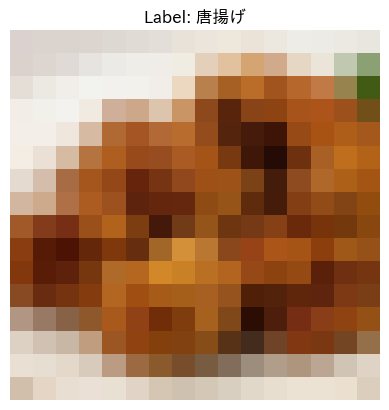

In [ ]:
def show_img(sample, class_name_list, pred=None, normalize=True):
    img_tensor = sample[0]
    label = class_name_list[sample[1]]
    if pred is not None:
        assert type(pred)==int
        pred = class_name_list[pred]
    plt.figure()
    if pred:
        plt.title(f'Label: {label} Pred: {pred}')
    else:
        plt.title(f'Label: {label}')
    img_array = img_tensor.permute(1, 2, 0).numpy() # (C, H, W) -> (H, W, C)
    if not normalize:
        # 正規化を元に戻す
        img_array = img_array * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()

show_img(scraped_dataset[0], scraped_dataset.class_name_list, normalize=False) # 正規化後の画像で可視化するか指定可能

# 3. 畳み込みニューラルネットワークの構築
コンピュータビジョン分野では，ニューラルネットワークの中でも**畳み込みニューラルネットワーク**（*CNN; Convolutional Neural Network*）と呼ばれるものが多く使われています． これは人間の視覚機能をヒントに発明されたもので，畳み込み（下記のコードでは`Conv2d()`）とプーリング（下記のコードでは`max_pool2d()`）と呼ばれる処理を繰り返すことで画像中の様々なパターンを捉えます．

まずは，下記のシンプルなCNNを使って画像からクラスを分類してみましょう．

演習 3.1: 下記のコードがエラーなく実行できることを確かめてください．  

演習 3.2: 実行すると，データセット内の一つ目のデータに対するCNNの出力結果が表示されます．この出力は何を意味していますか？  

演習 3.3: コードの中では，`Conv2d()`や`max_pool2d()`に`kernel_size`や`padding`といったオプションが設定されています．これらの意味や，他にどんなオプションがあるかを調べてみましょう．また，元コードではouthやoutw（各層を通った後の特徴量のサイズ）などの変数がハードコーディングされています．この値を自由に変更しても問題なく動作するように`init()`内の変数定義を書き換え，エラーなく実行が完了するようにしましょう．

**ヒント：畳み込み層の前後で，入出力の次元の関係は以下の式を満たします（参考: https://qiita.com/DeepTama/items/379cac9a73c2aed7a082 ）．**

**出力サイズ =｛(入力サイズ + 2 × パディングサイズ - カーネルサイズ) / ストライドサイズ｝+ 1**

演習 3.4: 元のコードのCNNは，畳み込みとプーリングを2回ずつ行っています．ここにコードを書き加え，畳み込みとプーリングをもう1回ずつ実行するように変更してみてください．


In [ ]:
class CNN(nn.Module):
    def __init__(self, class_num, img_size):
        super(CNN, self).__init__()
        self.img_size = img_size  # 画像サイズ

        # 畳み込み層1を定義（入力チャネルRGB=3、出力チャネル32、3x3カーネル）
        self.conv1_outc = 32  # 特徴マップの数を増加
        self.conv1 = nn.Conv2d(3, self.conv1_outc, kernel_size=3, padding=1, stride=1)

        # conv1後の出力サイズを計算
        self.conv1_outh = int((self.img_size[0] + 2 * self.conv1.padding[0] - self.conv1.kernel_size[0]) / self.conv1.stride[0] + 1)
        self.conv1_outw = int((self.img_size[1] + 2 * self.conv1.padding[1] - self.conv1.kernel_size[1]) / self.conv1.stride[1] + 1)

        self.pool1_size = 2
        # プーリング1後の出力サイズ（サイズ半減）
        self.pool1_outh = int(self.conv1_outh / self.pool1_size)
        self.pool1_outw = int(self.conv1_outw / self.pool1_size)

        # 畳み込み層2（出力チャネル64）
        self.conv2_outc = 64
        self.conv2 = nn.Conv2d(self.conv1_outc, self.conv2_outc, kernel_size=3, padding=1, stride=1)

        # conv2後の出力サイズ
        self.conv2_outh = int((self.pool1_outh + 2 * self.conv2.padding[0] - self.conv2.kernel_size[0]) / self.conv2.stride[0] + 1)
        self.conv2_outw = int((self.pool1_outw + 2 * self.conv2.padding[1] - self.conv2.kernel_size[1]) / self.conv2.stride[1] + 1)

        self.pool2_size = 2
        # プーリング2後の出力サイズ
        self.pool2_outh = int(self.conv2_outh / self.pool2_size)
        self.pool2_outw = int(self.conv2_outw / self.pool2_size)

        # 畳み込み層3（出力チャネル128）
        self.conv3_outc = 128
        self.conv3 = nn.Conv2d(self.conv2_outc, self.conv3_outc, kernel_size=3, padding=1, stride=1)

        # conv3後の出力サイズ
        self.conv3_outh = int((self.pool2_outh + 2 * self.conv3.padding[0] - self.conv3.kernel_size[0]) / self.conv3.stride[0] + 1)
        self.conv3_outw = int((self.pool2_outw + 2 * self.conv3.padding[1] - self.conv3.kernel_size[1]) / self.conv3.stride[1] + 1)

        self.pool3_size = 2
        # プーリング3後の出力サイズ
        self.pool3_outh = int(self.conv3_outh / self.pool3_size)
        self.pool3_outw = int(self.conv3_outw / self.pool3_size)

        # 全結合層の入力サイズ（最後のプーリング出力を平坦化）
        self.fc1_in = self.conv3_outc * self.pool3_outh * self.pool3_outw
        self.fc1_out = 512  # 中間層の出力ユニット数

        # 全結合層の定義
        self.fc1 = nn.Linear(self.fc1_in, self.fc1_out)
        self.fc2 = nn.Linear(self.fc1_out, class_num)  # 出力層はクラス数と同じ

    def forward(self, x):
        batch_size = x.shape[0]

        # 畳み込み → ReLU → プーリング1
        x = F.relu(self.conv1(x))
        assert x.shape[2] == self.conv1_outh and x.shape[3] == self.conv1_outw, 'テンソルのサイズ計算を見直してください．'
        x = F.max_pool2d(x, kernel_size=self.pool1_size)
        assert x.shape[2] == self.pool1_outh and x.shape[3] == self.pool1_outw, 'テンソルのサイズ計算を見直してください．'

        # 畳み込み → ReLU → プーリング2
        x = F.relu(self.conv2(x))
        assert x.shape[2] == self.conv2_outh and x.shape[3] == self.conv2_outw, 'テンソルのサイズ計算を見直してください．'
        x = F.max_pool2d(x, kernel_size=self.pool2_size)
        assert x.shape[2] == self.pool2_outh and x.shape[3] == self.pool2_outw, 'テンソルのサイズ計算を見直してください．'

        # 畳み込み → ReLU → プーリング3
        x = F.relu(self.conv3(x))
        assert x.shape[2] == self.conv3_outh and x.shape[3] == self.conv3_outw, 'テンソルのサイズ計算を見直してください．'
        x = F.max_pool2d(x, kernel_size=self.pool3_size)
        assert x.shape[2] == self.pool3_outh and x.shape[3] == self.pool3_outw, 'テンソルのサイズ計算を見直してください．'

        # 特徴マップをベクトル化
        x = x.view(batch_size, -1)
        assert x.shape[1] == self.fc1_in

        # 全結合層 → ReLU → 出力層
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        x = F.softmax(x, dim=1)
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN(class_num_scraped, img_size) # CNNを初期化
model.to(device) # モデルをGPUまたはCPUに載せる

# サンプルで動作を確認
sample_input, label = scraped_dataset[0]
sample_input = sample_input.unsqueeze(0)
sample_input = sample_input.to(device)
print(sample_input.shape)
sample_output = model(sample_input)
print(sample_output)

print(scraped_dataset.class_name_list[sample_output.argmax()])

torch.Size([1, 3, 16, 16])
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward0>)
トイプードル


# 4. 画像分類の学習と評価
ここまででデータセットとモデルを構築できたので，いよいよモデルの学習に移ります．

今回の実験では2回目の最後にテストデータに対する分類性能を比較しますので，それまでは手元のデータを学習データと検証データに分割して使用します．

演習 4.1: 以前の講義では自分自身で学習データと検証データに分割しましたが，PyTorchには`random_split()`のようにデータセットの分割を自動で行うメソッドが存在します．これを使って，学習データ，検証データ，テストデータを7:1:2の割合で分割してみましょう．

参考（PyTorchのドキュメント）: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

演習 4.2: 以前の講義資料を参考に，適切な損失関数と最適化手法を設定してみましょう．

演習 4.3: 以前の講義資料を参考に，モデルの出力結果から特定のクラスを予測結果に定め，その結果を基に検証データにおける正解率を算出してみましょう．

演習 4.4: 下記のコードがエラーなく実行できるようにしてください．

演習 4.5: 検証データの中で，予測に成功した画像と失敗した画像をそれぞれ可視化してみましょう．何か傾向は見られるでしょうか．

In [ ]:
# 学習用のループ
def train(bar, model, train_loader, criterion, optimizer, epoch, device):
    model.train()
    epoch_loss = 0
    samples = 0
    TP = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # 勾配情報をリセット
        outputs = model(images) # モデルの出力

        loss = criterion(outputs, labels) # 出力と正解ラベルを比較し損失計算
        loss.backward() # 誤差逆伝播
        optimizer.step() # モデルのパラメータを更新

        pred = torch.argmax(outputs) # 予測クラスを取得する
        TP += (pred == labels).sum().item() # ミニバッチ内のTPをカウントする

        epoch_loss += copy.deepcopy(loss.item()) * images.size(0) # ミニバッチ内の損失を合計値に加算
        samples += images.size(0)
        accuracy = TP / samples # 正解率を更新する
        bar.set_description(f'Epoch {epoch+1} Train {samples/len(train_loader.dataset)*100:.0f}% Loss: {epoch_loss/samples:.4f}, Accuracy: {accuracy*100:.2f}% ({TP:.0f}/{samples})')

    return epoch_loss / samples, accuracy

# 検証用のループ
def val(bar, model, val_loader, criterion, epoch, device):
    model.eval()
    epoch_loss = 0
    samples = 0
    TP = 0
    with torch.no_grad(): # モデルの重みを更新しないので勾配を計算しなくて良い
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            pred = torch.argmax(outputs) # 予測クラスを取得する
            TP += (pred == labels).sum().item() # ミニバッチ内のTPをカウントする

            epoch_loss += loss.item() * images.size(0) # エポック全体の損失の合計値を更新する
            samples += images.size(0)
            accuracy = TP / samples # 正解率を更新する
            bar.set_description(f'Epoch {epoch+1} Val {samples/len(val_loader.dataset)*100:.0f}% Loss: {epoch_loss/samples:.4f}, Accuracy: {accuracy*100:.2f}% ({TP:.0f}/{samples})')

    return epoch_loss / samples, accuracy

def loop(train_loader, val_loader, model, num_epoch, criterion, optimizer, device, save_name="model"):
    print('Training...', end='')
    bar = tqdm.tqdm(range(num_epoch), leave=True)
    result = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in bar:
        train_loss, train_acc = train(bar, model, train_loader, criterion, optimizer, epoch=epoch, device=device)
        result['train_loss'].append(train_loss)
        result['train_acc'].append(train_acc)

        val_loss, val_acc = val(bar, model, val_loader, criterion, epoch=epoch, device=device)
        result['val_loss'].append(val_loss)
        result['val_acc'].append(val_acc)
    print(f'Done!')

    # 学習したモデルの重み（パラメータ）を保存する
    torch.save(model.state_dict(), os.path.join(save_name + ".pth"))

    # 学習中の性能の推移を可視化
    report_result(result)

def report_result(result):
    # visualize the loss curve
    plt.figure()
    plt.plot(result['train_loss'], label='train')
    plt.plot(result['val_loss'], label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    plt.close()

    # visualize the accuracy curve
    plt.figure()
    plt.plot(result['train_acc'], label='train')
    plt.plot(result['val_acc'], label='val')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    plt.close()

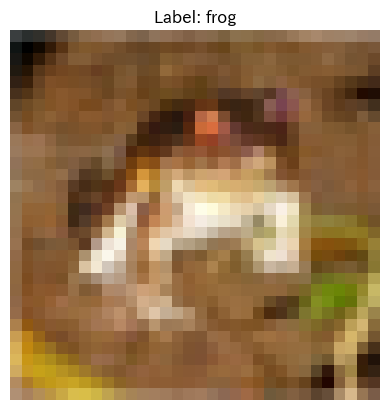

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataset.py:473: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


学習データ数：10000，検証データ数：2500，テストデータ数：10000
クラス数: 10
画像サイズ：(32, 32)
Training...

Epoch 5 Val 100% Loss: 2.0903, Accuracy: 0.00% (0/2500): 100%|██████████| 5/5 [02:19<00:00, 27.86s/it]


Done!


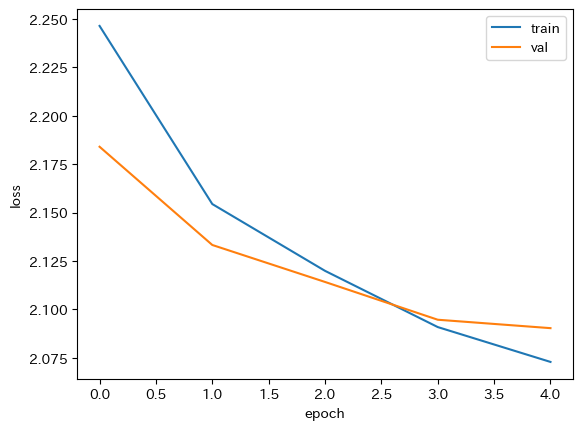

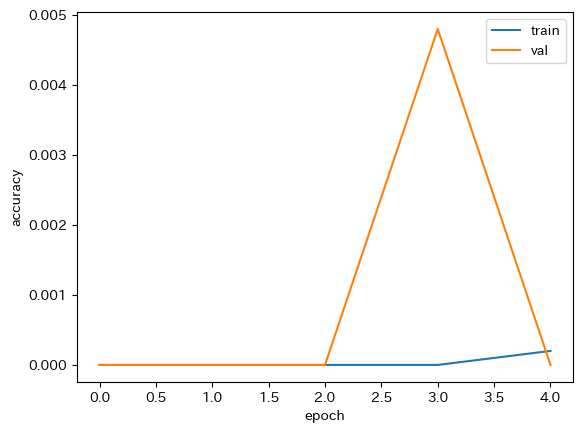

In [ ]:
# 指定した条件で学習を実行
dataset = "CIFAR"
# dataset = "SCRAPED"

# 画像サイズを定義
img_size = (64, 64)

# 学習用の前処理を定義 (必要に応じてデータ拡張を追加)
transform_train = transforms.Compose([
    transforms.ToTensor(), # 読み込んだPIL ImageをTensorに変換
    transforms.Resize(img_size), # 指定した画像サイズにリサイズ
    ### 新たな前処理を追加可能 ###
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 画素値の正規化．平均と分散の値はImageNetデータセットの値に準じる．
])

# 検証用・テスト用の前処理を定義
transform_test = transforms.Compose([
    transforms.ToTensor(), # Tensorへの変換
    transforms.Resize(img_size), # リサイズ
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 画素値の正規化
])

if dataset=="CIFAR":
    # CIFARの学習データセットを読み込み
    cifar_dataset = CIFAR(root='./data', train=True, download=True, transform=transform_train)
    show_img(cifar_dataset[0], cifar_dataset.classes, normalize=False) # 正規化後の画像で可視化するか指定可能

    # 学習データと検証データを分割
    # dataset_train, dataset_val, _ = torch.utils.data.random_split(cifar_dataset, [0.8, 0.2, 0.0])
    dataset_train, dataset_val, _ = torch.utils.data.random_split(cifar_dataset, [0.2, 0.05, 0.75])

    # CIFARのテストデータセットを読み込み
    dataset_test = CIFAR(root='./data', train=False, download=True, transform=transform_test)

    # CIFARのクラス数に更新
    class_num = len(cifar_dataset.classes)

elif dataset=="SCRAPED":
    # 学習データ，検証データ，テストデータを分割
    scraped_dataset = ScrapedDataset(class_names=keywords, img_size=img_size, transform=transform_train)
    dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(scraped_dataset, [0.7, 0.1, 0.2])
    class_num = class_num_scraped
else:
    raise Exception("データセットはCIFARかSCRAPEDから選択してください．")

print(f'学習データ数：{len(dataset_train)}，検証データ数：{len(dataset_val)}，テストデータ数：{len(dataset_test)}')
print(f'クラス数: {class_num}')
print(f'画像サイズ：{img_size}')

# データローダーを定義
train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset_val, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=False, num_workers=2)

# モデルを定義
model = CNN(class_num, img_size) # CNNを初期化
model.to(device) # モデルをGPUまたはCPUに載せる

# 損失関数を定義
criterion = nn.CrossEntropyLoss()

# 最適化手法や学習率を定義
# optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 学習のエポック数を設定（デバッグ時は小さい値にすると良い）
num_epoch = 5

loop(train_loader, val_loader, model, num_epoch, criterion, optimizer, device, save_name="model_scraped")

# 5. 分類性能の向上
ここまでで，データの収集，前処理，モデルの構築，モデルの学習を経て分類性能を評価することができました．最終的に得られるモデルの分類性能は，これらすべてに左右されて決まります．ここからは，これまでに実装してきた内容に独自に工夫を加え，分類性能の向上を目指してください．

演習 5.1: 収集したデータの中に，学習に悪影響を与えそうなものはありませんか．そのような画像をデータセットから除いたり，収集するデータを増やしたりするとどうなりますか．

演習 5.2: 前処理を変更することで性能がどのように変化するか確認しましょう．前処理にも適切なものとそうでないものがあります．

演習 5.3: モデルの構成を見直し，性能を向上させてみましょう．層を増やすだけでなく，活性化関数などの種類も見直しましょう．

演習 5.4: 学習条件を見直し，性能を向上させてみましょう．最適化手法や学習のエポック数など，調整できる点が多々あります．

演習 5.5: 唐揚げとプードルの分類でtest accuracy 1.0 を達成しましょう．達成出来たらノートブック上部の`dataset`を`CIFAR`に切り替え，そちらの性能向上を目指してください．

発展 5.6: モデルの予測結果に何か傾向がないか調べてみましょう．予測に成功/失敗した画像を可視化したり，クラスごとの正解率などの統計量を算出したりといった手があります．

発展 5.7: 深層学習では，過学習と呼ばれる問題がよく発生します．過学習されたモデルはトレーニングデータに対して過剰にフィットし（答えの丸暗記のようなもの），トレーニングデータに対する性能は向上しますが検証データやテストデータに対する性能が悪化します．過学習の対策方法について調べてみましょう．学習データのバリエーションを増やすことはその一つです．

発展 5.8: CNNに限らずよく用いられる強力なテクニックに残差接続（*residual connection*）というものがあるので，興味がある人は調べて実装してみると良いでしょう．

参考（残差接続の解説と実装）: https://euske.github.io/introdl/lec8/index.html

# 6. 分類性能のテスト
下記のコードでは，学習時に`save_name.pth`に保存したモデルを用いてテストデータの画像クラスを予測します．
唐揚げプードル分類とCIFAR10の分類それぞれで性能向上を目指してください．
２回目の最後には，コンペ形式でCIFAR10での分類性能を評価します．
正解率の向上以外にも，学習効率の改善など，独自の取り組みを期待します．

取り組みのねらい，内容，結果をレポートにまとめてpdf形式で提出してください．

コンペの注意点：
- スクレイピングのデータ数は自由に増やして構いません．
- スクレイピングのキーワードやクラス数も自由に変更して構いません．
- モデルはCNN以外のものを独自に定義，使用しても構いません．

In [ ]:
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f} % ({int(correct)}/{total})')

# モデルを再構築し、学習済みの重みをロード
test_model = CNN(class_num, img_size)
model_save_name = "model_scraped.pth" # 学習させたモデルファイル名に修正してください
test_model.load_state_dict(torch.load(model_save_name, map_location=device))
test_model.to(device)

# テストデータで評価
print(f'{dataset}データセットでの評価結果：')
test(test_model, test_loader, device)

SCRAPEDデータセットでの評価結果：
Test Accuracy: 90.00 % (9/10)
